# Introduction

### Motivation

With the number of choices and brands in supermarkets multiplying, it would take great effort to manually sort through items one by one. Hence this project aims to help sort supermarket items by its brand and type. 

Ideally this can lead to more ambitious projects such as automated checkout systems, item management systems, product recommendation, or even pricing and discounts to help maximize profit. 

### Methodology

1. Build data set of items using a web scraper.
2. Build a Convoluted Neural Network (CNN) to perform classification on items.

# Build Data Set

In [208]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import urllib
import numpy as np
import matplotlib.pyplot as plt
import captum

from PIL import Image
from random import randint
from skimage.transform import resize
from torchvision import transforms

Mounting Google Drive to store images of items.

In [2]:
import sys, os
from google.colab import drive

if 'google.colab' in sys.modules:
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/items_dataset'
    print(path_to_file)
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/items_dataset
/content/gdrive/My Drive/items_dataset


In [3]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.4t4cfbBnMS/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.8qU50GVLMW/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.GKOiKih2S2/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian bust

In [11]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import selenium

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=options)

Web scraper to obtain relevant images. Manual filtering is done after to remove irrelevant images.

In [26]:
search = 'smarties+chocolate'
filename = 'smarties'

url = 'https://www.google.ca/search?q='+search+'&tbm=isch&oq='+search
driver.get(url)

last_height = driver.execute_script('return document.body.scrollHeight')
while True:
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight)')
    time.sleep(2)
    new_height = driver.execute_script('return document.body.scrollHeight')
    try:
        driver.find_element(by=By.XPATH, value='//*[@id="islmp"]/div/div/div/div/div[5]/input').click()
        time.sleep(2)
    except:
        pass
    if new_height == last_height:
        break
    last_height = new_height

download_location = '/content/gdrive/MyDrive/items_dataset/' + filename + "/"

imgNum = 500
downloaded = 0

for i in range(1, imgNum):
    try:
        img = driver.find_element(by=By.XPATH, value='//*[@id="islrg"]/div[1]/div['+str(i)+']/a[1]/div[1]/img')
        src = img.get_attribute('src')
        urllib.request.urlretrieve(src, download_location + filename + "(" + str(i) + ").jpg")
        downloaded += 1
    except:
        continue

print("Number of downloaded images:", downloaded)

Number of downloaded images: 185


Mapping of brands to its tag.

In [342]:
brands = {
  "arla" : 0,
  "philadelphia" : 1,
  "laughing_cow" : 2,
  "campbell" : 3,
  "heinz" : 4,
  "spam" : 5,
  "haribo" : 6,
  "mentos" : 7,
  "skittles" : 8,
  "smarties" : 9,
}

Converts images into tensors -> compresses them in 32x32 pixel images -> include 4 rotations of each images. 

In [56]:
filename = "smarties"
download_location = '/content/gdrive/MyDrive/items_dataset/' + filename + "/"

img_tensors = []
convert_tensor = transforms.ToTensor()

# Standardise size for all images
for i in range(1, imgNum):
    try:
        img = Image.open(download_location + filename + "(" + str(i) + ").jpg")
    except:
        continue

    img = img.resize((32, 32))

    # Add different rotations
    for angle in range (0, 360, 90):
        rotated = img.rotate(angle)

        # Convert file from jpg to tensor
        x = convert_tensor(rotated)

        # Add tensor to list
        img_tensors.append(x)

data_location = '/content/gdrive/MyDrive/items_dataset/data/' + filename + 'Tensor/'
os.makedirs(data_location)

# Create the same number of brand labels and type labels
label_arr = [brands[filename]] * len(img_tensors)
label_tensors = torch.as_tensor(label_arr)

type_arr = [types[filename]] * len(img_tensors)
type_tensors = torch.as_tensor(type_arr)

# Save tensors to file only after all jpgs have been converted
torch.save(img_tensors, data_location + filename + 'Tensor.pt')
torch.save(label_tensors, data_location + filename + 'Labels.pt')
torch.save(type_tensors, data_location + filename + 'TypeLabels.pt')

print("Number of tensors created:", len(img_tensors))
print("Size of 1 tensor:", img_tensors[0].size() )

Number of tensors created: 560
Size of 1 tensor: torch.Size([3, 32, 32])


In [57]:
names = brands.keys()
data_tensors = []
brand_labels = []
type_labels = []
for filename in names:
  data_location = '/content/gdrive/MyDrive/items_dataset/data/' + filename + 'Tensor/'
  data = torch.load(data_location + filename + 'Tensor.pt')
  brand = torch.load(data_location + filename + 'Labels.pt')
  typelab = torch.load(data_location + filename + 'TypeLabels.pt')

  data_tensors += data
  brand_labels += brand
  type_labels += typelab

torch.save(data_tensors, '/content/gdrive/MyDrive/items_dataset/data/dataTensors.pt')
torch.save(brand_labels, '/content/gdrive/MyDrive/items_dataset/data/brandLabels.pt')
torch.save(type_labels, '/content/gdrive/MyDrive/items_dataset/data/typeLabels.pt')

print("Total number of tensors:", len(data_tensors))

Total number of tensors: 5892


Filter out grayscale images.

In [58]:
data = torch.load('/content/gdrive/MyDrive/items_dataset/data/dataTensors.pt')
brands = torch.load('/content/gdrive/MyDrive/items_dataset/data/brandLabels.pt')
types = torch.load('/content/gdrive/MyDrive/items_dataset/data/typeLabels.pt')

filtered_data = []
filtered_brands = []
filtered_types = []

for i in range(0, 4800):
    if (data[i].size(0) == 3):
        filtered_data.append(data[i])
        filtered_brands.append(brands[i])
        filtered_types.append(types[i])

# Save to a different file for insurance, remove the "Cleaned" part after
torch.save(filtered_data, '/content/gdrive/MyDrive/items_dataset/data/dataTensorsCleaned.pt')
torch.save(filtered_brands, '/content/gdrive/MyDrive/items_dataset/data/brandLabelsCleaned.pt')
torch.save(filtered_types, '/content/gdrive/MyDrive/items_dataset/data/typeLabelsCleaned.pt')

print("Final total number of usable tensors:", len(filtered_data))

Final total number of usable tensors: 4696


In [59]:

# Load in the intial data sets
total_data = torch.load("data/dataTensorsCleaned.pt")
type_labels = torch.load("data/typeLabelsCleaned.pt")
brand_labels = torch.load("data/brandLabelsCleaned.pt")

# Check the size of each dataset and the individual tensors
num_total_data = len(total_data)
tensor_size = total_data[0].size()
type_label_size = len(type_labels)
brand_label_size = len(brand_labels)
print(f"There are {num_total_data} images, each of them is of size {tensor_size}.")
print(f"There are {type_label_size} and {brand_label_size} labels for product types and brand respectively.")

There are 4696 images, each of them is of size torch.Size([3, 32, 32]).
There are 4696 and 4696 labels for product types and brand respectively.


Separation of data into training and test sets with a ratio of 7:3.

In [60]:
train_num = 0.7
test_num = 1 - train_num
print(f"{train_num * 100}% of total data is used for training, {test_num * 100}% is used for testing.")

num_train_data = int(train_num * num_total_data)
num_test_data = num_total_data - num_train_data

data_and_labels = list(zip(total_data, brand_labels, type_labels))
random.shuffle(data_and_labels)
shuffled_data, shuffled_brand_labels, shuffled_type_labels = zip(*data_and_labels)

train_data = torch.stack(shuffled_data[0:num_train_data])
test_data = torch.stack(shuffled_data[num_train_data:])

train_brand_labels = torch.stack(shuffled_brand_labels[0:num_train_data])
test_brand_labels = torch.stack(shuffled_brand_labels[num_train_data:])

train_type_labels = torch.stack(shuffled_type_labels[0:num_train_data])
test_type_labels = torch.stack(shuffled_type_labels[num_train_data:])

print(f"{num_train_data} training data, {num_test_data} test data")

70.0% of total data is used for training, 30.000000000000004% is used for testing.
3287 training data, 1409 test data


# Build Convoluted Neural Network (CNN)

Obtain mean and standard deviation to normalize data during training.

In [61]:
mean = train_data.mean()
print("The mean of the training set is:", mean)

std = train_data.std()
print("The standard deviation of the training set is:", std)

The mean of the training set is: tensor(0.6805)
The standard deviation of the training set is: tensor(0.2930)


Convoluted Neural Network model.

❗LeakyReLU leads to overfitting.

❗Being ambitious by starting with 64x64 images gives diminishing returns as it takes too long to train.

In [140]:
class CNN(nn.Module):

    def __init__(self, output_size):

        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
            nn.Conv2d(3,   64,  kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(64,  64,  kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # block 2:         64 x 16 x 16 --> 128 x 8 x 8
            nn.Conv2d(64,  128, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
            nn.Conv2d(128, 256, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #block 4:          256 x 4 x 4 --> 512 x 2 x 2
            nn.Conv2d(256, 512, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.linear = nn.Sequential(
            # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
            nn.Linear(2048, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, output_size)
        )


    def forward(self, x):

        x = self.conv(x)
        x = x.view(-1, 2048)
        x = self.linear(x) 
        
        return x

In [141]:
brand_CNN_net = CNN(10)
     


In [142]:
brand_CNN_criterion = nn.CrossEntropyLoss()
brand_CNN_lr = 0.001 
bs = 50

In [143]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

Evaluation function to test model on the fly so that we can know if we are underfitting/overfitting to minimise time wastage.

In [144]:
def eval_on_test_set(net, labels):

    running_error = 0
    num_batches = 0

    for i in range(0, num_test_data, bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label = labels[i:i+bs]

        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores , minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches

    print('test error=', total_error*100, 'percent')

Training of data using mini batch gradient descent + Adam optimiser.

In [145]:
start = time.time()

for epoch in range(15):
    
    # create a new optimizer at the beginning of each epoch; give the current learning rate.   
    brand_Adam_CNN_optimizer = torch.optim.Adam(brand_CNN_net.parameters() , lr=brand_CNN_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_brand_loss = 0
    running_brand_error = 0
    num_batches = 0
    
    # set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
    
        # Set the gradients to zeros
        brand_Adam_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_brand_labels = train_brand_labels[indices] # difference between brand & type training
        
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = brand_CNN_net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        brand_loss = brand_CNN_criterion(scores, minibatch_brand_labels) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        brand_loss.backward()

        # Do one step of the optimizer
        brand_Adam_CNN_optimizer.step()
        

        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_brand_loss += brand_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error       
        brand_error = get_error(scores.detach(), minibatch_brand_labels)
        running_brand_error += brand_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_brand_loss = running_brand_loss/num_batches
    total_brand_error = running_brand_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=', epoch, '\t total time=', elapsed, 'min', '\t lr=', brand_CNN_lr, '\t loss=', total_brand_loss, '\t error=', total_brand_error*100, 'percent')

    eval_on_test_set(brand_CNN_net, test_brand_labels) 
    print(' ')

epoch= 0 	 total time= 2.080293627580007 min 	 lr= 0.001 	 loss= 2.1510099407398338 	 error= 86.23013956980272 percent
test error= 80.23754707698164 percent
 
epoch= 1 	 total time= 4.381713537375132 min 	 lr= 0.001 	 loss= 1.8857889699213433 	 error= 75.09500429485783 percent
test error= 70.05364011073935 percent
 
epoch= 2 	 total time= 6.669209897518158 min 	 lr= 0.001 	 loss= 1.7540847586862969 	 error= 69.92219487826029 percent
test error= 68.36015314891421 percent
 
epoch= 3 	 total time= 8.972634820143382 min 	 lr= 0.001 	 loss= 1.6160268928065444 	 error= 60.9082716884035 percent
test error= 51.22605295016848 percent
 
epoch= 4 	 total time= 11.266331871350607 min 	 lr= 0.001 	 loss= 1.3663208665269795 	 error= 49.895986372774296 percent
test error= 48.25287399620846 percent
 
epoch= 5 	 total time= 13.5559303800265 min 	 lr= 0.001 	 loss= 1.2308290510466604 	 error= 44.23996688741626 percent
test error= 38.83524886493025 percent
 
epoch= 6 	 total time= 15.860016679763794 min 

# Analysis

final training set error: 12.952%

final test set error: 17.280%

In [146]:
def show_prob_brand(p):
    p=p.data.squeeze().numpy()

    ft=15
    label = ('arla', 'philadelphia', 'laughing_cow', 'campbell', 'heinz', 'spam', 'haribo', 'mentos', 'skittles', 'smarties')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)

    plt.show()

In [147]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

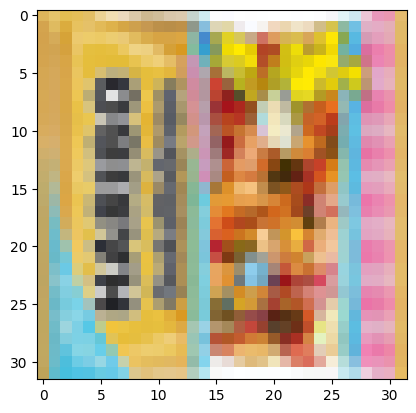

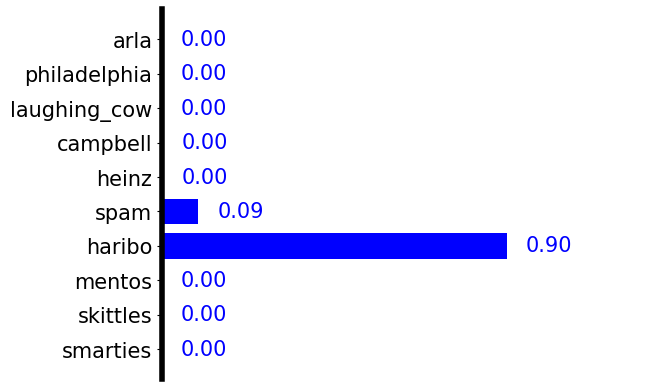

In [148]:
# Choose a picture at random
idx = randint(0, num_test_data)
im = test_data[idx]

# diplay the picture
show(im)

# send to device, rescale, and view as a batch of 1 
im = (im-mean) / std
im = im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores = brand_CNN_net(im) 
probs = torch.softmax(scores, dim=1)
show_prob_brand(probs.cpu())

A simple heatmap generated using captum to make sure the AI is identifying the correct parts of the image.

true class:  spam
predicated class:  spam


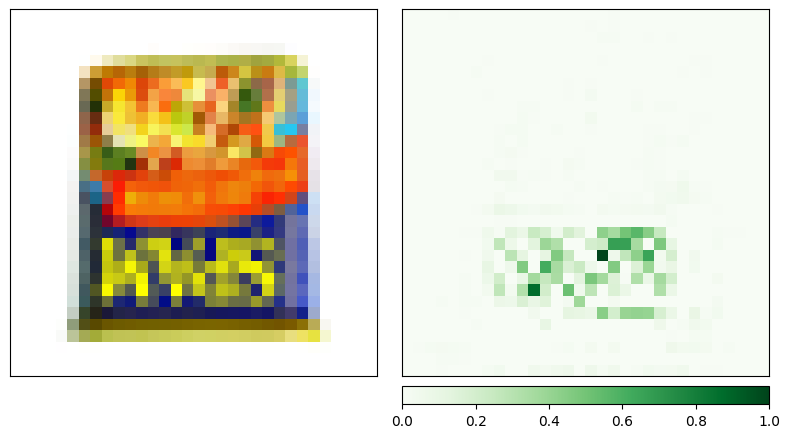

In [341]:
brand_classes = [
    "arla",
    "philadelphia",
    "laughing_cow",
    "campbell",
    "heinz",
    "spam",
    "haribo",
    "mentos",
    "skittles",
    "smarties"
]

rand_idx = randint(0, num_test_data)

def_x = test_data[rand_idx] # test image
x = (def_x-mean) / std
x = x.view(1,3,32,32)
y = test_brand_labels[rand_idx] # associated test label

brand_CNN_net.eval()
scores = brand_CNN_net(x) # get the raw scores
probs = scores.data.squeeze()
probs, idx = probs.sort(0, True)

print('true class: ', brand_classes[y])
print('predicated class: ', brand_classes[idx[0]])

assert y == idx[0], "We want to visualize what the model is focusing on for a correct prediction, run again for another random sample!"

ig = captum.attr.IntegratedGradients(brand_CNN_net)
attribution = (ig.attribute(x, target=y))


_ = captum.attr.visualization.visualize_image_attr_multiple(np.transpose(attribution.squeeze().numpy(), (1,2,0)), 
                                                   np.transpose(def_x.squeeze().numpy(), (1,2,0)), 
                                                   methods=["original_image", "heat_map"],
                                                   signs=['all', 'positive'],
                                                   show_colorbar =True)
